## **Data Collecting**

In [ ]:
!pip install pmdarima --q # untuk arima otomatis
!pip install prophet --q # untuk fbprophet

In [ ]:
# Import library yang diperlukan
import os
import pandas as pd
import numpy as np
import seaborn as sns  # Import library seaborn untuk visualisasi
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Import library preprocessing
from sklearn.model_selection import train_test_split  # Import library untuk pemisahan data
import matplotlib.pyplot as plt
from datetime import datetime, date #Library to deal with datetime columns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Baca dataset
data1 = pd.read_csv('/content/drive/MyDrive/Dataset/ispu_dki1.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Dataset/ispu_dki2.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Dataset/ispu_dki3.csv')
data4 = pd.read_csv('/content/drive/MyDrive/Dataset/ispu_dki4.csv')
data5 = pd.read_csv('/content/drive/MyDrive/Dataset/ispu_dki5.csv')
data6 = pd.read_csv('/content/drive/MyDrive/Dataset/ispu_20.csv')

# Gabungkan data secara vertikal (tambahkan baris)
data_AQ = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

# Simpan data yang telah digabungkan ke dalam file CSV dengan nama "data_AQ.csv"
output_dir = '/content/drive/MyDrive/Dataset'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
data_AQ.to_csv(os.path.join(output_dir, 'data_AQ1.csv'), index=False)
print("Data telah disimpan di:", os.path.join(output_dir, 'data_AQ1.csv'))


# Cetak lokasi file yang telah disimpan
print("Data telah disimpan di:", os.path.join(output_dir, '/content/drive/MyDrive/Dataset/data_AQ1.csv'))

Data telah disimpan di: /content/drive/MyDrive/Dataset/data_AQ1.csv
Data telah disimpan di: /content/drive/MyDrive/Dataset/data_AQ1.csv


In [ ]:
# Melihat tipe data setiap kolom
data_AQ.dtypes

tanggal     object
stasiun     object
pm10        object
so2         object
co          object
o3          object
no2         object
max          int64
critical    object
categori    object
dtype: object

In [ ]:
# Melihat jumlah baris dan kolom
data_AQ.shape

(21350, 10)

In [ ]:
print(data_AQ.isnull().sum())

tanggal       0
stasiun       0
pm10        758
so2         568
co          392
o3          646
no2         528
max           0
critical      0
categori      0
dtype: int64


In [ ]:
# Memeriksa keberadaan garis '---' dalam setiap kolom
for column in data_AQ.columns:
    if data_AQ[column].dtype == 'object':  # Hanya memeriksa kolom dengan tipe data objek (string)
        contains_dash = data_AQ[column].str.contains('---').any()
        if contains_dash:
            print(f"Garis '---' ditemukan dalam kolom {column}")
        else:
            print(f"Tidak ada garis '---' dalam kolom {column}")

Tidak ada garis '---' dalam kolom tanggal
Tidak ada garis '---' dalam kolom stasiun
Garis '---' ditemukan dalam kolom pm10
Garis '---' ditemukan dalam kolom so2
Garis '---' ditemukan dalam kolom co
Garis '---' ditemukan dalam kolom o3
Garis '---' ditemukan dalam kolom no2
Tidak ada garis '---' dalam kolom critical
Tidak ada garis '---' dalam kolom categori


In [ ]:
# Mengganti garis '---' dengan nilai NaN dalam kolom-kolom yang mengandung garis tersebut
for column in data_AQ.columns:
    if data_AQ[column].dtype == 'object' and data_AQ[column].str.contains('---').any():
        data_AQ[column] = data_AQ[column].replace('---', np.nan)

# Menyimpan dataset setelah penggantian nilai garis '---' dengan NaN dengan nama file yang sama
data_AQ.to_csv('data_AQ.csv', index=False)

In [ ]:
print(data_AQ.isnull().sum())

tanggal       0
stasiun       0
pm10        808
so2         611
co          406
o3          656
no2         568
max           0
critical      0
categori      0
dtype: int64


In [ ]:
# Baca data CSV (Ganti 'data_AQ.csv' dengan nama file Anda)
data_AQ = pd.read_csv('data_AQ.csv')

# Daftar kolom untuk menangani nilai hilang
kolom_dengan_nilai_hilang = ['pm10', 'so2', 'co', 'o3', 'no2']

# Iterasi melalui setiap kolom dan ganti nilai hilang
for kolom in kolom_dengan_nilai_hilang:
    data_AQ[kolom].replace(to_replace=[None, np.NAN, ''], value=np.NAN, inplace=True)

# Hapus baris dengan nilai NaN (Opsional)
data_AQ.dropna(subset=kolom_dengan_nilai_hilang, inplace=True)

# Verifikasi tipe data (Opsional)
print(data_AQ.dtypes)

tanggal      object
stasiun      object
pm10        float64
so2         float64
co          float64
o3          float64
no2         float64
max           int64
critical     object
categori     object
dtype: object


In [ ]:
# Menginstall dan mengimpor library dateparser
!pip install dateparser

import dateparser

In [ ]:
# Mengonversi kolom tanggal menjadi string
# Pastikan kolom tanggal berisi string yang dapat di-parse menjadi tanggal
data_AQ['tanggal'] = data_AQ['tanggal'].astype(str)
# Tangani nilai-nilai yang tidak valid atau tidak dapat di-parse menjadi tanggal
data_AQ['tanggal'] = data_AQ['tanggal'].apply(lambda x: dateparser.parse(x) if dateparser.parse(x) is not None else np.nan)


# Mengubah tipe data kolom critical menjadi kategorikal
data_AQ['critical'] = data_AQ['critical'].astype('category')

# Mengubah tipe data kolom kategori menjadi kategorikal
data_AQ['categori'] = data_AQ['categori'].astype('category')
# Menyimpan dataset setelah perubahan tipe data
data_AQ.to_csv('data_AQ', index=False)

In [ ]:
# Mengonversi kolom 'tanggal' menjadi tipe data datetime
data_AQ['tanggal'] = pd.to_datetime(data_AQ['tanggal'], errors='coerce')

# Mencetak jumlah nilai NaT dalam kolom 'tanggal'
print(data_AQ['tanggal'].isnull().sum())

# Jika ada nilai NaT yang tidak terkonversi dengan baik, Anda dapat memeriksanya
if data_AQ['tanggal'].isnull().sum() > 0:
    print("Nilai NaT yang tidak terkonversi dengan baik:")
    print(data_AQ[data_AQ['tanggal'].isnull()]['tanggal'])

    # Menghapus baris dengan nilai NaT dalam kolom 'tanggal'
    data_AQ.dropna(subset=['tanggal'], inplace=True)


0


In [ ]:
# Menampilkan nilai-nilai unik dalam kolom 'stasiun'
unique_values = data_AQ['stasiun'].unique()
print(unique_values)

['DKI1 (Bunderan HI)' 'DKI2 (Kelapa Gading)' 'DKI3 (Jagakarsa)'
 'DKI4 (Lubang Buaya)' 'DKI5 (Kebon Jeruk)'
 'DKI5 (Kebon Jeruk) Jakarta Barat' '45' '34' '59' '56' '35' '36' '37'
 '39' '30' '40' '48' '64' '50' '41' '44' '62' '43' '58' '33' '49' '61'
 '47' '51' '42' '55' '54' '65' '53' '27' '71' '52' '63' '60' '66' '38'
 '32' '74' '76' '70' '89' '69' '101' '57' '73' '78' '24' '25']


In [ ]:
# Membuat filter untuk baris yang mengandung 'DKI' dalam kolom 'stasiun'
dki_filter = data_AQ['stasiun'].str.contains('DKI')

# Mengaplikasikan filter untuk memperbarui dataframe
data_AQ = data_AQ[dki_filter]

# Memeriksa nilai-nilai unik setelah membersihkan
print(data_AQ['stasiun'].unique())

['DKI1 (Bunderan HI)' 'DKI2 (Kelapa Gading)' 'DKI3 (Jagakarsa)'
 'DKI4 (Lubang Buaya)' 'DKI5 (Kebon Jeruk)'
 'DKI5 (Kebon Jeruk) Jakarta Barat']


In [ ]:
# Mengganti nilai 'DKI5 (Kebon Jeruk) Jakarta Barat' dengan 'DKI5 (Kebon Jeruk)'
data_AQ['stasiun'] = data_AQ['stasiun'].replace('DKI5 (Kebon Jeruk) Jakarta Barat', 'DKI5 (Kebon Jeruk)')

# Mengonversi tipe data kolom stasiun menjadi string
data_AQ['stasiun'] = data_AQ['stasiun'].astype(str)

print(data_AQ['stasiun'].value_counts())

stasiun
DKI1 (Bunderan HI)      4273
DKI2 (Kelapa Gading)    4096
DKI3 (Jagakarsa)        3674
DKI4 (Lubang Buaya)     3592
DKI5 (Kebon Jeruk)      3027
Name: count, dtype: int64


In [ ]:
print(data_AQ.isnull().sum())

tanggal     0
stasiun     0
pm10        0
so2         0
co          0
o3          0
no2         0
max         0
critical    0
categori    0
dtype: int64


In [ ]:
# Verifikasi tipe data
print(data_AQ.dtypes)

tanggal     datetime64[ns]
stasiun             object
pm10               float64
so2                float64
co                 float64
o3                 float64
no2                float64
max                  int64
critical          category
categori          category
dtype: object


In [ ]:
# Simpan DataFrame yang sudah dibersihkan ke file CSV baru
data_AQ.to_csv('data_AQ1.csv', index=False)

In [ ]:
# Baca dataset
data = pd.read_csv('/content/data_AQ1.csv')

# Cetak informasi dataset awal
print(f"Jumlah baris awal: {data.shape[0]}")
print(f"Kolom: {data.columns}")

# Cek duplikasi data
duplikat = data.duplicated()

# Hitung jumlah baris duplikasi
jumlah_duplikat = duplikat.sum()

# Cetak informasi duplikasi
print(f"Jumlah baris duplikasi: {jumlah_duplikat}")

# Tampilkan beberapa contoh baris duplikat (opsional)
if jumlah_duplikat > 0:
    print("\nContoh baris duplikat:")
    data[duplikat].head()

# Hapus baris duplikasi
try:
    data_tanpa_duplikat = data.drop_duplicates()
except Exception as e:
    print(f"Gagal menghapus duplikasi: {e}")
    data_tanpa_duplikat = data

# Cetak informasi dataset setelah dihapus duplikasinya
print("\nInformasi dataset setelah dihapus duplikasi:")
print(f"Jumlah baris: {data_tanpa_duplikat.shape[0]}")
print(f"Kolom: {data_tanpa_duplikat.columns}")

# Simpan data tanpa duplikasi ke dataset baru
try:
    data_tanpa_duplikat.to_csv('data_AQ1.csv', index=False)
except Exception as e:
    print(f"Gagal menyimpan data: {e}")

Jumlah baris awal: 18662
Kolom: Index(['tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')
Jumlah baris duplikasi: 1381

Contoh baris duplikat:

Informasi dataset setelah dihapus duplikasi:
Jumlah baris: 17281
Kolom: Index(['tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')


Memanggil Dataset

In [ ]:
df = pd.read_csv('/content/data_AQ1.csv')

Deskripsi Dataset

categori
SEDANG                11771
BAIK                   2920
TIDAK SEHAT            2395
SANGAT TIDAK SEHAT      194
BERBAHAYA                 1
Name: count, dtype: int64 




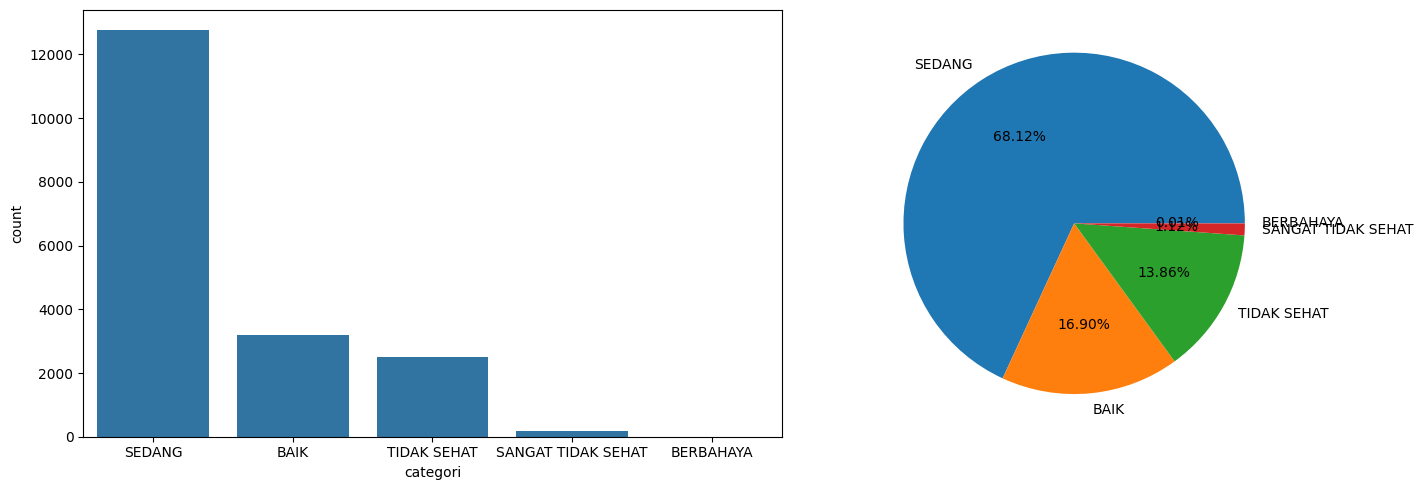

In [ ]:
target  = "categori"

val_counts = df[target].value_counts()
print(val_counts, "\n\n")

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x = data[target])

plt.subplot(1, 2, 2)
plt.pie(val_counts, labels = val_counts.keys(), autopct = "%.2f%%")

plt.tight_layout()
plt.show()

In [ ]:
df.head()

,tanggal,stasiun,pm10,so2,co,o3,no2,max,critical,categori
0,2010-01-01,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25,PM10,BAIK


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17281 entries, 0 to 17280
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   17281 non-null  object 
 1   stasiun   17281 non-null  object 
 2   pm10      17281 non-null  float64
 3   so2       17281 non-null  float64
 4   co        17281 non-null  float64
 5   o3        17281 non-null  float64
 6   no2       17281 non-null  float64
 7   max       17281 non-null  int64  
 8   critical  17281 non-null  object 
 9   categori  17281 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.3+ MB


Transform Data

In [ ]:
df['tanggal'] = pd.to_datetime(df['tanggal'], format='%Y-%m-%d')

In [ ]:
df.set_index(['tanggal'], inplace=True)

In [ ]:
df.head()

,stasiun,pm10,so2,co,o3,no2,max,critical,categori
tanggal,,,,,,,,,
2010-01-01,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73,CO,SEDANG
2010-01-02,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33,O3,BAIK
2010-01-03,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27,PM10,BAIK
2010-01-04,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22,PM10,BAIK
2010-01-05,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25,PM10,BAIK


In [ ]:
df.index.min(), df.index.max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2021-12-31 00:00:00'))

In [ ]:
if (df.index.max() - df.index.min() == 214):
    print ('Data is Continous')

## **Modelling**

### **Analisa Time Series**


<Axes: xlabel='tanggal'>

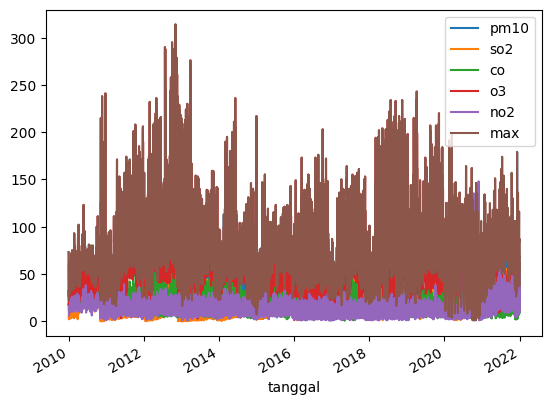

In [ ]:
df.plot()

In [ ]:
split = int(len(df)*0.8)
train_df = df[:split]
test_df =  df[split:]

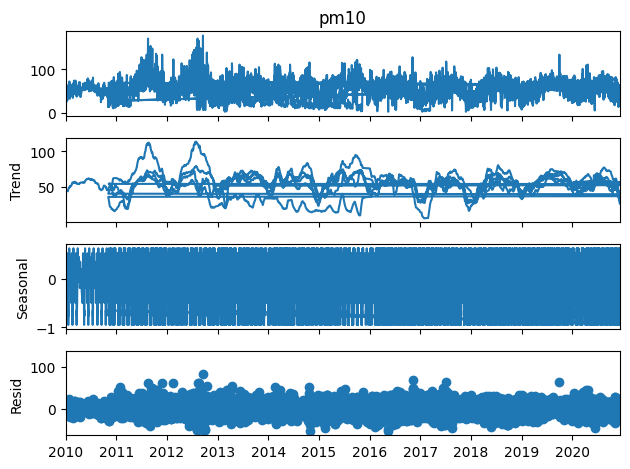

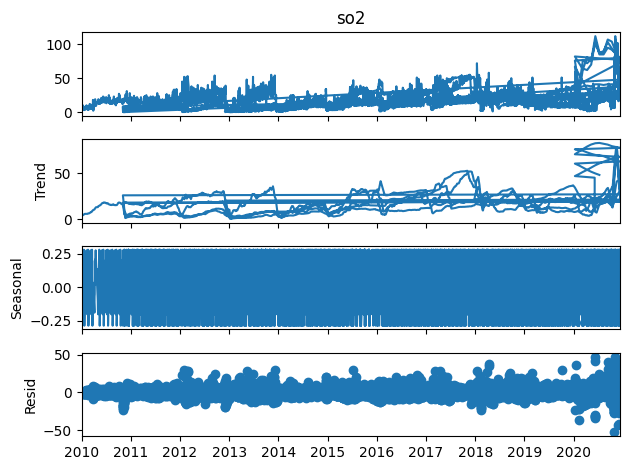

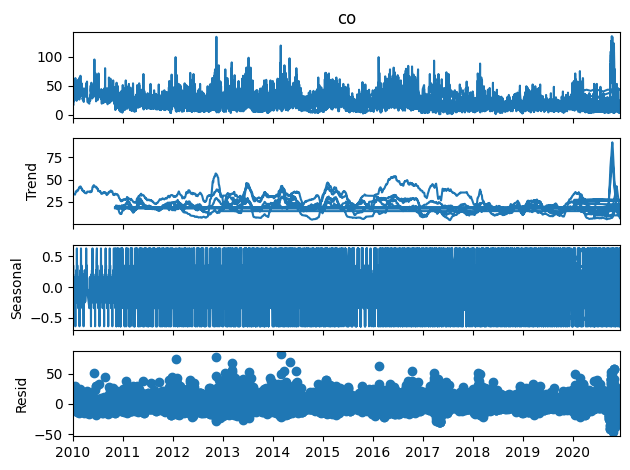

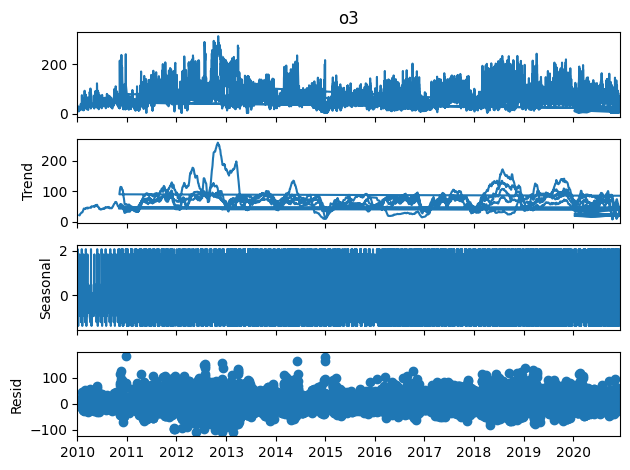

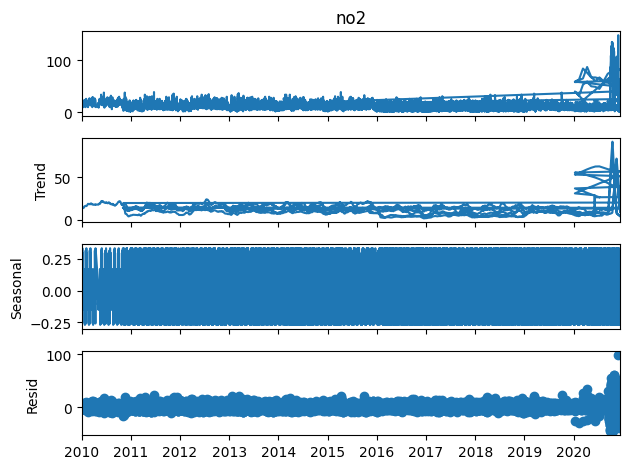

In [ ]:
p = ['pm10', 'so2', 'co', 'o3', 'no2']
for i in p:
  decompose_add = seasonal_decompose(df[i], period=30)
  decompose_add.plot()

In [ ]:
# Menguji stasioneritas dari beberapa kolom dalam suatu dataframe time series
def adf_test(ts):
    columns_to_test = ['pm10', 'so2', 'co', 'o3', 'no2']
    for column in columns_to_test:
        result = adfuller(ts[column])
        print(f'ADF Statistic for {column}: {result[0]}')
        print(f'p-value for {column}: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print('\n')

adf_test(df)

ADF Statistic for pm10: -9.85881953342341
p-value for pm10: 4.2873305568579254e-17
Critical Values:
   1%: -3.4307290803453947
   5%: -2.861707538720287
   10%: -2.5668591765381246


ADF Statistic for so2: -7.708875296022699
p-value for so2: 1.2796407268425888e-11
Critical Values:
   1%: -3.4307292122419986
   5%: -2.8617075970097163
   10%: -2.5668592075647303


ADF Statistic for co: -9.333064004497272
p-value for co: 9.217116115231575e-16
Critical Values:
   1%: -3.430729454290974
   5%: -2.86170770397908
   10%: -2.56685926450295


ADF Statistic for o3: -8.244734500839453
p-value for o3: 5.593559754423058e-13
Critical Values:
   1%: -3.430729410259089
   5%: -2.8617076845199496
   10%: -2.566859254145141


ADF Statistic for no2: -12.155827109375133
p-value for no2: 1.5329324475125948e-22
Critical Values:
   1%: -3.430729454290974
   5%: -2.86170770397908
   10%: -2.56685926450295




 stasioner memiliki arti bahwa sifat statistik data tidak berubah seiring waktu

In [ ]:
diff_df = df[p].diff()
diff_df.head()

,pm10,so2,co,o3,no2
tanggal,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-02,-28.0,-2.0,-57.0,6.0,-5.0
2010-01-03,-5.0,0.0,3.0,-13.0,0.0
2010-01-04,-5.0,0.0,-3.0,-5.0,-3.0
2010-01-05,3.0,0.0,1.0,0.0,2.0


In [ ]:
diff_df.dropna(inplace=True)

<Axes: xlabel='tanggal'>

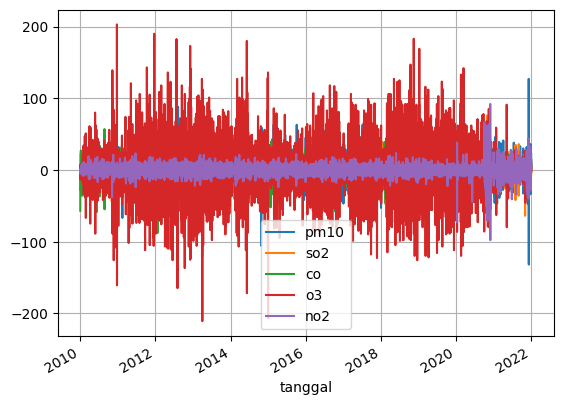

In [ ]:
diff_df.plot(grid=True)

In [ ]:
adf_test(diff_df)

ADF Statistic for pm10: -29.715888421939894
p-value for pm10: 0.0
Critical Values:
   1%: -3.430729322225968
   5%: -2.861707645615233
   10%: -2.566859233436732


ADF Statistic for so2: -25.691381386249034
p-value for so2: 0.0
Critical Values:
   1%: -3.4307294763107494
   5%: -2.861707713710339
   10%: -2.566859269682756


ADF Statistic for co: -27.520709222715592
p-value for co: 0.0
Critical Values:
   1%: -3.4307294763107494
   5%: -2.861707713710339
   10%: -2.566859269682756


ADF Statistic for o3: -28.24547148081613
p-value for o3: 0.0
Critical Values:
   1%: -3.430729410259089
   5%: -2.8617076845199496
   10%: -2.566859254145141


ADF Statistic for no2: -31.59999619490984
p-value for no2: 0.0
Critical Values:
   1%: -3.4307293442304183
   5%: -2.86170765533972
   10%: -2.5668592386129334




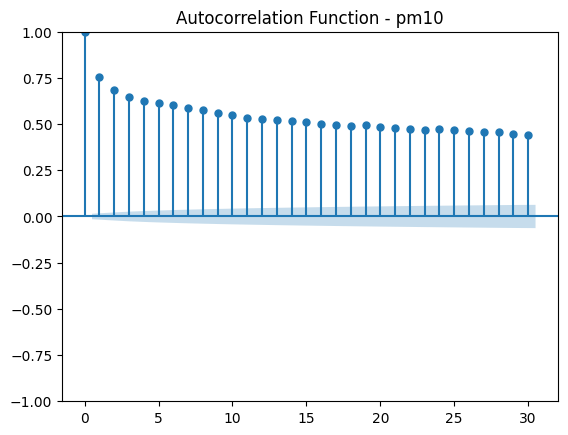

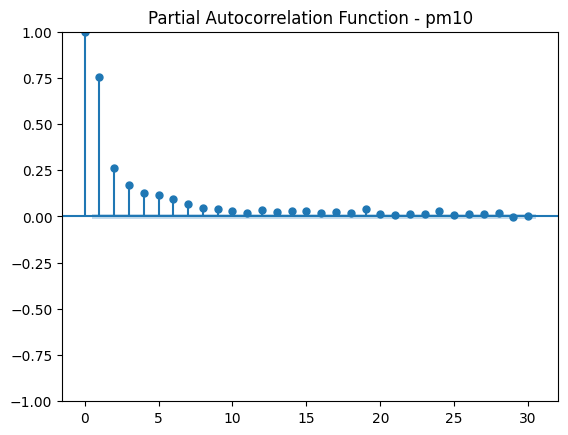

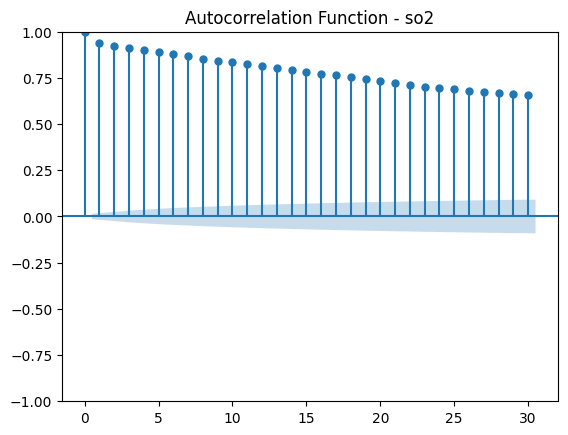

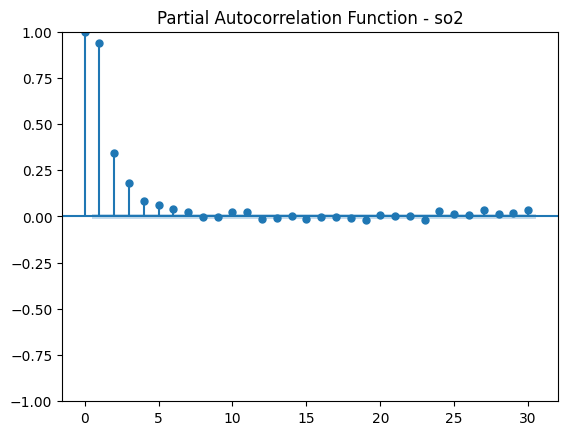

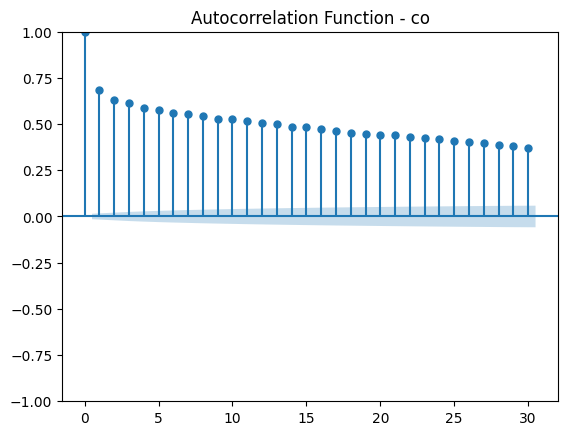

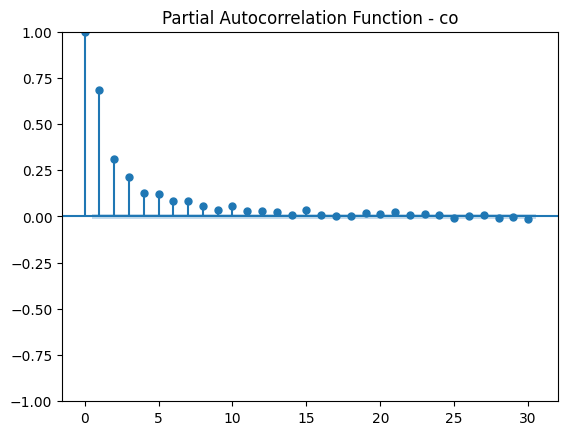

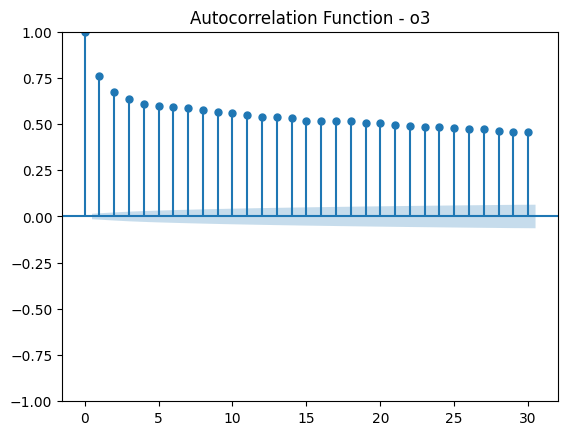

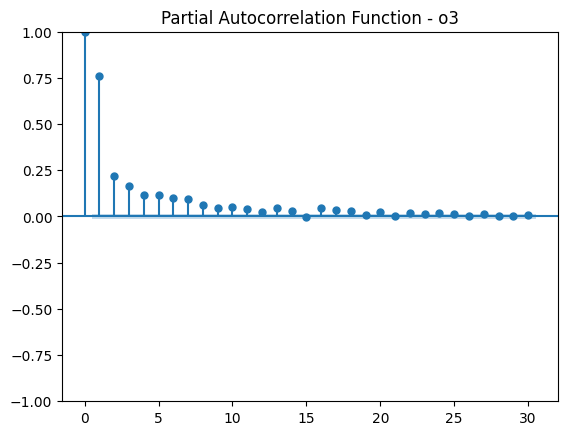

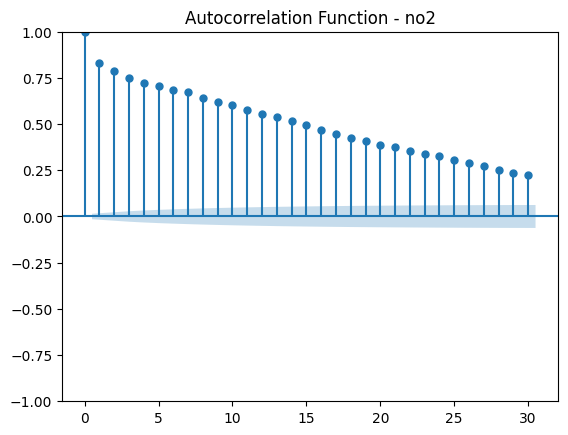

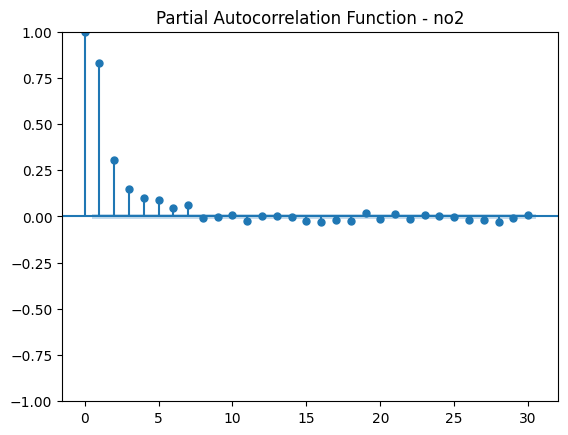

In [ ]:

for i in p:
  #Plot ACF
  plot_acf(df[i], lags=30, title=f'Autocorrelation Function - {i}')
  plt.show()

  # Plot PACF
  plot_pacf(df[i], lags=30, title=f'Partial Autocorrelation Function - {i}')
  plt.show()


In [ ]:
df_train = train_df.loc[train_df['stasiun'] == 'DKI1 (Bunderan HI)']
df_test = test_df.loc[test_df['stasiun'] == 'DKI1 (Bunderan HI)']

In [ ]:
df_train

,stasiun,pm10,so2,co,o3,no2,max,critical,categori
tanggal,,,,,,,,,
2010-01-01,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73,CO,SEDANG
2010-01-02,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33,O3,BAIK
2010-01-03,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27,PM10,BAIK
2010-01-04,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22,PM10,BAIK
2010-01-05,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25,PM10,BAIK
...,...,...,...,...,...,...,...,...,...
2021-12-27,DKI1 (Bunderan HI),52.0,61.0,15.0,20.0,15.0,71,PM25,SEDANG
2021-12-28,DKI1 (Bunderan HI),51.0,53.0,15.0,18.0,13.0,65,PM25,SEDANG
2021-12-29,DKI1 (Bunderan HI),31.0,54.0,10.0,24.0,11.0,54,SO2,SEDANG


In [ ]:
df_test

,stasiun,pm10,so2,co,o3,no2,max,critical,categori
tanggal,,,,,,,,,
2020-06-06,DKI1 (Bunderan HI),55.0,16.0,5.0,65.0,9.0,65,O3,SEDANG
2020-06-06,DKI1 (Bunderan HI),59.0,15.0,5.0,33.0,10.0,59,PM10,SEDANG
2020-06-06,DKI1 (Bunderan HI),58.0,14.0,6.0,41.0,12.0,58,PM10,SEDANG
2020-06-06,DKI1 (Bunderan HI),67.0,16.0,10.0,34.0,10.0,67,PM10,SEDANG
2020-06-06,DKI1 (Bunderan HI),63.0,16.0,6.0,40.0,10.0,63,PM10,SEDANG
2020-06-06,DKI1 (Bunderan HI),49.0,15.0,6.0,58.0,13.0,58,O3,SEDANG
2020-06-06,DKI1 (Bunderan HI),60.0,16.0,6.0,61.0,10.0,61,O3,SEDANG
2020-06-06,DKI1 (Bunderan HI),60.0,15.0,6.0,61.0,12.0,61,O3,SEDANG
2020-06-06,DKI1 (Bunderan HI),70.0,13.0,8.0,54.0,13.0,70,PM10,SEDANG


### **Single Exponential Smoothing**

len(single_exp_train_pred[pm10])=3950
len(single_exp_test_pred[pm10])=35


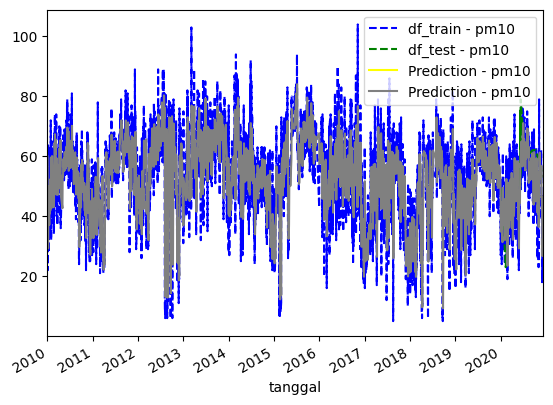

Train RMSE - pm10: 10.698804398751912
Test RMSE - pm10: 12.441074663586598
Train MAPE - pm10: 0.19617068789569303
Test MAPE - pm10: 0.18140073131538612
len(single_exp_train_pred[so2])=3950
len(single_exp_test_pred[so2])=35


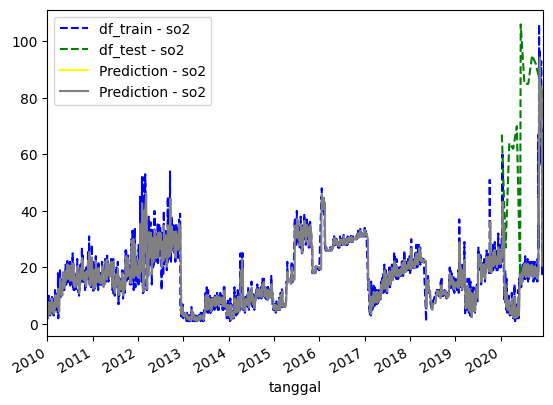

Train RMSE - so2: 3.7874585657357134
Test RMSE - so2: 34.45190099727073
Train MAPE - so2: 0.16889734867631237
Test MAPE - so2: 1.6247552023693659
len(single_exp_train_pred[co])=3950
len(single_exp_test_pred[co])=35


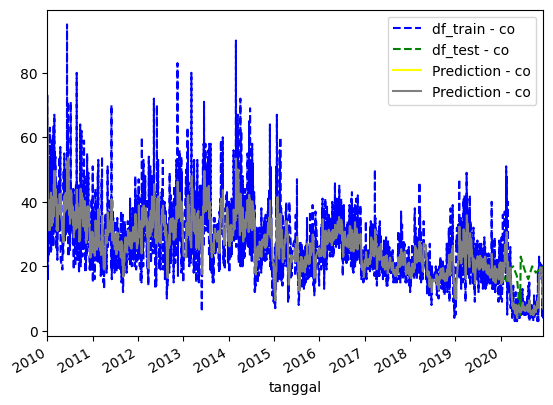

Train RMSE - co: 7.313139308217773
Test RMSE - co: 8.439437696905483
Train MAPE - co: 0.22310210222633053
Test MAPE - co: 1.1195071661973877
len(single_exp_train_pred[o3])=3950
len(single_exp_test_pred[o3])=35


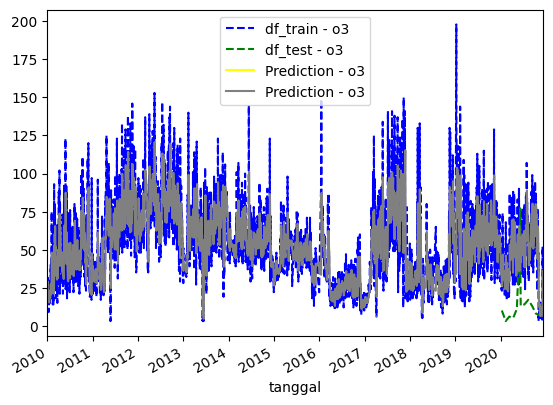

Train RMSE - o3: 17.24767306208919
Test RMSE - o3: 27.942585527201285
Train MAPE - o3: 0.29369879378769936
Test MAPE - o3: 0.9590101892710428
len(single_exp_train_pred[no2])=3950
len(single_exp_test_pred[no2])=35


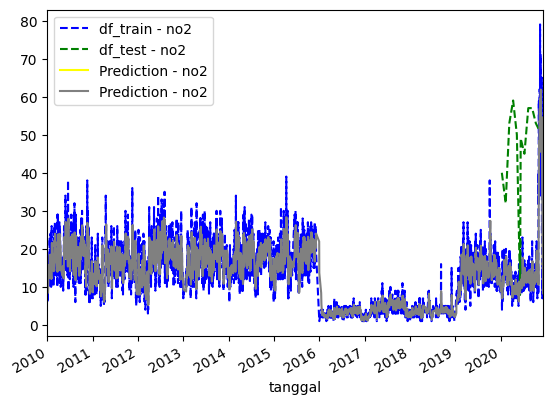

Train RMSE - no2: 4.448065048103829
Test RMSE - no2: 20.89785803788174
Train MAPE - no2: 0.25812395130113613
Test MAPE - no2: 0.4004176066700917


In [ ]:

ses_model = {}
single_exp_train_pred = {}
single_exp_test_pred = {}
for i in p:
  ses_model[i] = SimpleExpSmoothing(df_train[i]).fit()
  single_exp_train_pred[i] = ses_model[i].fittedvalues
  single_exp_test_pred[i] = ses_model[i].forecast(35)
  print(f'len(single_exp_train_pred[{i}])={len(single_exp_train_pred[i])}')
  print(f'len(single_exp_test_pred[{i}])={len(single_exp_test_pred[i])}')
  df_train[i].plot(style='--', color='blue', legend=True, label=f'df_train - {i}')
  df_test[i].plot(style='--', color='green', legend=True, label=f'df_test - {i}')
  single_exp_test_pred[i].plot(color='yellow', legend=True, label=f'Prediction - {i}')
  single_exp_train_pred[i].plot(color='grey', legend=True, label=f'Prediction - {i}')
  plt.xlim('2010-01-01', '2020-12-11')
  plt.show()
  print(f'Train RMSE - {i}:',mean_squared_error(df_train[i], single_exp_train_pred[i])**0.5)
  print(f'Test RMSE - {i}:', mean_squared_error(df_test[i], single_exp_test_pred[i])**0.5)
  print(f'Train MAPE - {i}:', mean_absolute_percentage_error(df_train[i], single_exp_train_pred[i]))
  print(f'Test MAPE - {i}:', mean_absolute_percentage_error(df_test[i], single_exp_test_pred[i]))

### **Double Exponential Smoothing**

len(double_exp_train_pred[pm10])=3950
len(double_exp_test_pred[pm10])=35


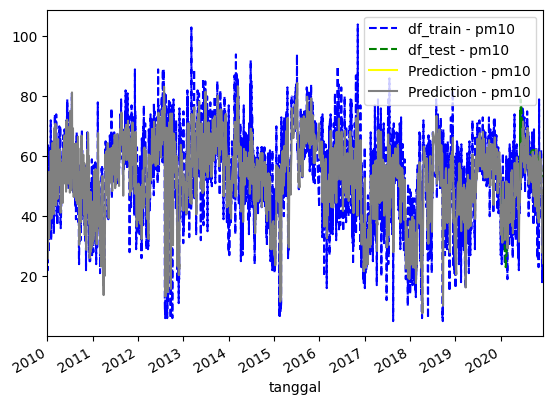

Train RMSE - pm10: 10.935808428335507
Test RMSE - pm10: 12.8154160258248
Train MAPE - pm10: 0.20307702818490286
Test MAPE - pm10: 0.17953690083041215
len(double_exp_train_pred[so2])=3950
len(double_exp_test_pred[so2])=35


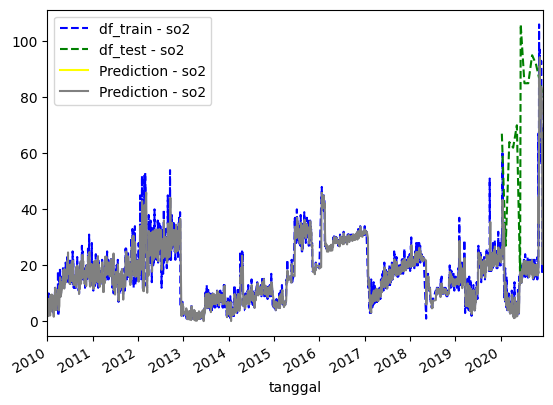

Train RMSE - so2: 3.85738009687788
Test RMSE - so2: 34.55275670903445
Train MAPE - so2: 0.17837063853019433
Test MAPE - so2: 1.6320928525827387
len(double_exp_train_pred[co])=3950
len(double_exp_test_pred[co])=35


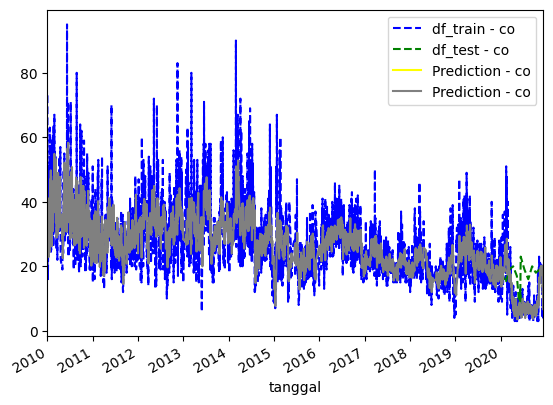

Train RMSE - co: 7.43747385054877
Test RMSE - co: 8.830036017867124
Train MAPE - co: 0.23322055605085704
Test MAPE - co: 1.167842661125177
len(double_exp_train_pred[o3])=3950
len(double_exp_test_pred[o3])=35


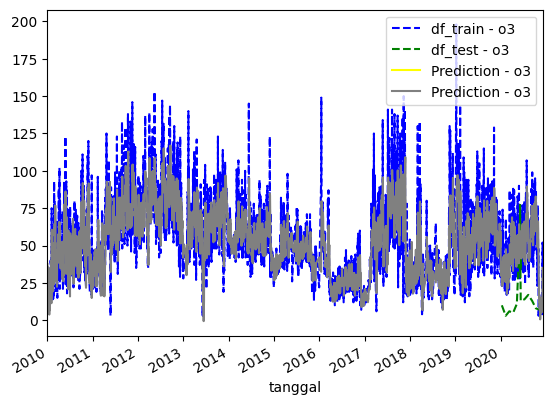

Train RMSE - o3: 17.74779372672348
Test RMSE - o3: 25.788856806647715
Train MAPE - o3: 0.31526324294444585
Test MAPE - o3: 0.9094601297625152
len(double_exp_train_pred[no2])=3950
len(double_exp_test_pred[no2])=35


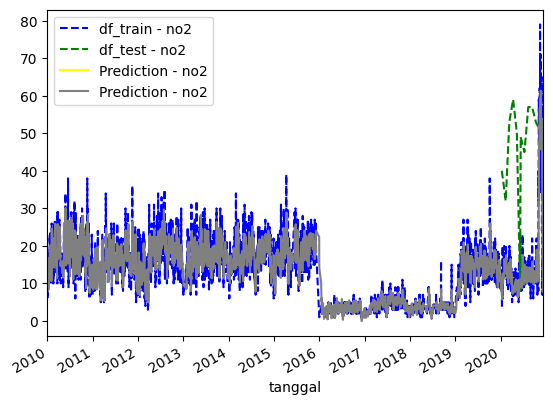

Train RMSE - no2: 4.567221818053814
Test RMSE - no2: 20.972068443968155
Train MAPE - no2: 0.2759917547275387
Test MAPE - no2: 0.4151408377698153


In [ ]:

des_model = {}
double_exp_train_pred = {}
double_exp_test_pred = {}
for i in p:
  des_model[i] = double_exp = ExponentialSmoothing(df_train[i], trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
  double_exp_train_pred[i] = des_model[i].fittedvalues
  double_exp_test_pred[i] = des_model[i].forecast(35)
  print(f'len(double_exp_train_pred[{i}])={len(double_exp_train_pred[i])}')
  print(f'len(double_exp_test_pred[{i}])={len(double_exp_test_pred[i])}')
  df_train[i].plot(style='--', color='blue', legend=True, label=f'df_train - {i}')
  df_test[i].plot(style='--', color='green', legend=True, label=f'df_test - {i}')
  double_exp_test_pred[i].plot(color='yellow', legend=True, label=f'Prediction - {i}')
  double_exp_train_pred[i].plot(color='grey', legend=True, label=f'Prediction - {i}')
  plt.xlim('2010-01-01', '2020-12-11')
  plt.show()
  print(f'Train RMSE - {i}:',mean_squared_error(df_train[i], double_exp_train_pred[i])**0.5)
  print(f'Test RMSE - {i}:', mean_squared_error(df_test[i], double_exp_test_pred[i])**0.5)
  print(f'Train MAPE - {i}:', mean_absolute_percentage_error(df_train[i], double_exp_train_pred[i]))
  print(f'Test MAPE - {i}:', mean_absolute_percentage_error(df_test[i], double_exp_test_pred[i]))



### **SARIMA**

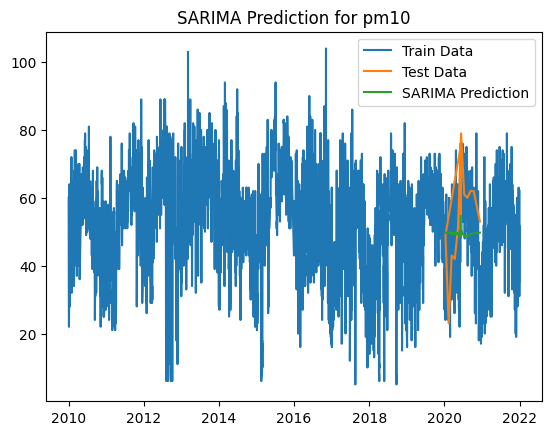

Train RMSE for pm10: 10.59388233715364
Test RMSE for pm10: 14.754222925921745
Train MAPE for pm10: 0.20282209099832704
Test MAPE for pm10: 0.21413609459424082


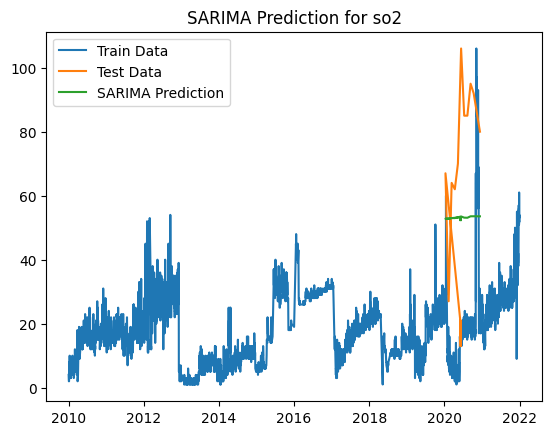

Train RMSE for so2: 3.7982170497431116
Test RMSE for so2: 34.35471862731786
Train MAPE for so2: 0.17414332797710255
Test MAPE for so2: 1.62465515541986


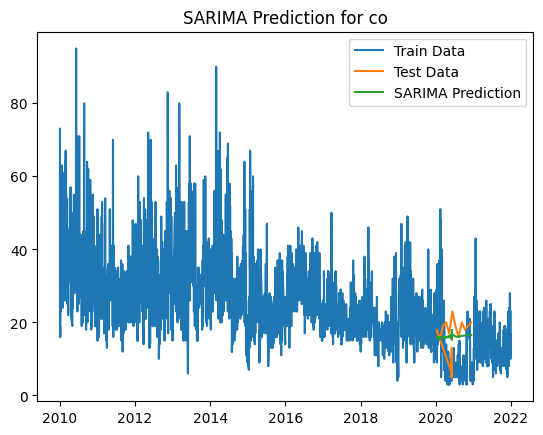

Train RMSE for co: 7.476946677502999
Test RMSE for co: 8.146028037902507
Train MAPE for co: 0.22572606056089334
Test MAPE for co: 1.0770287723391823


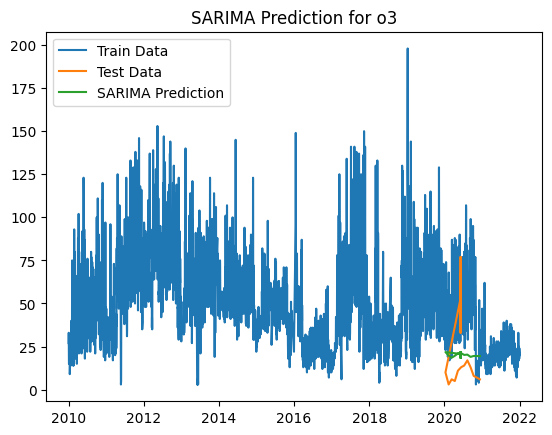

Train RMSE for o3: 16.58024219868852
Test RMSE for o3: 28.45424862235982
Train MAPE for o3: 0.30504125283578515
Test MAPE for o3: 0.9203872813757422


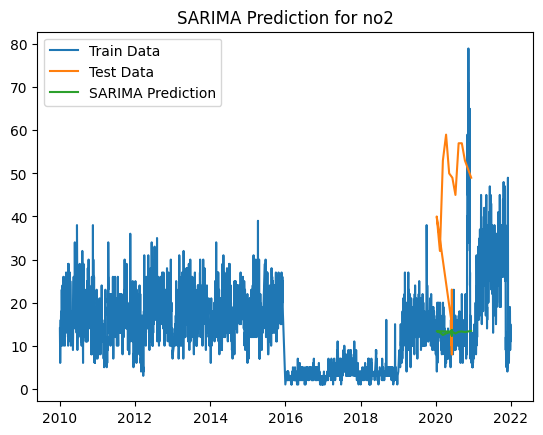

Train RMSE for no2: 4.40744751471613
Test RMSE for no2: 21.038099497175796
Train MAPE for no2: 0.255777985394244
Test MAPE for no2: 0.3925490465096392


In [ ]:
sarima_model = {}
sarima_train_pred = {}
sarima_test_pred = {}
for i in p:
    # Fitting SARIMA model
    sarima_model[i] = SARIMAX(df_train[i], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

    # Melakukan prediksi pada data pelatihan
    sarima_train_pred[i] = sarima_model[i].predict(start=df_train.index.min(), end=df_train.index.max(), dynamic=False)

    # Melakukan prediksi untuk data uji
    sarima_test_pred[i] = sarima_model[i].forecast(steps=len(df_test))

    # Memplot hasil prediksi
    plt.plot(df_train.index, df_train[i], label='Train Data')
    plt.plot(df_test.index, df_test[i], label='Test Data')
    plt.plot(df_test.index, sarima_test_pred[i], label='SARIMA Prediction')
    plt.title(f'SARIMA Prediction for {i}')
    plt.legend()
    plt.show()

    # Menghitung RMSE dan MAPE
    train_rmse = mean_squared_error(df_train[i], sarima_train_pred[i], squared=False)
    test_rmse = mean_squared_error(df_test[i], sarima_test_pred[i], squared=False)
    train_mape = mean_absolute_percentage_error(df_train[i], sarima_train_pred[i])
    test_mape = mean_absolute_percentage_error(df_test[i], sarima_test_pred[i])

    # Menampilkan hasil evaluasi
    print(f'Train RMSE for {i}: {train_rmse}')
    print(f'Test RMSE for {i}: {test_rmse}')
    print(f'Train MAPE for {i}: {train_mape}')
    print(f'Test MAPE for {i}: {test_mape}')


### **ARIMA**

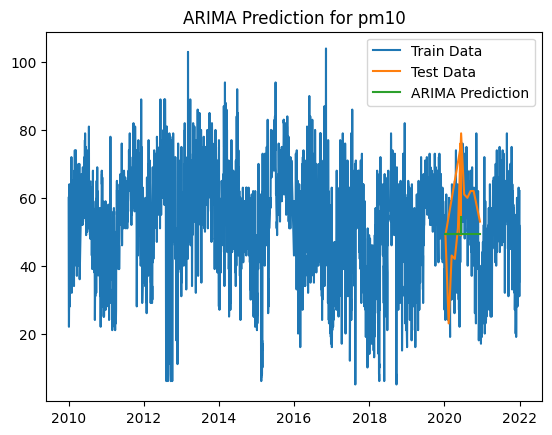

Train RMSE for pm10: 10.45316612924243
Test RMSE for pm10: 14.832003574283195
Train MAPE for pm10: 0.20039858608569072
Test MAPE for pm10: 0.21429082570766486


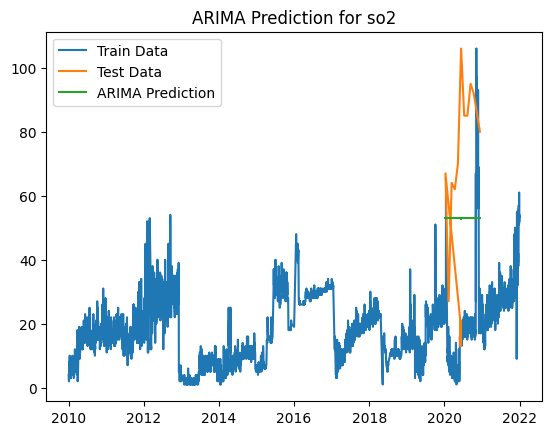

Train RMSE for so2: 3.7767713057901138
Test RMSE for so2: 34.537261316510325
Train MAPE for so2: 0.16790426602998024
Test MAPE for so2: 1.6313808797575158


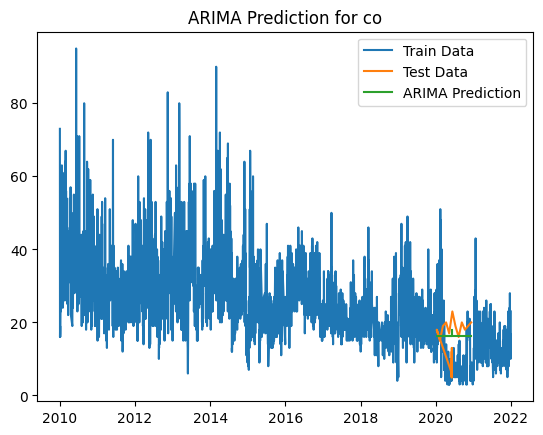

Train RMSE for co: 7.238682528206799
Test RMSE for co: 8.204038454138356
Train MAPE for co: 0.2218308235843998
Test MAPE for co: 1.0878538453571507


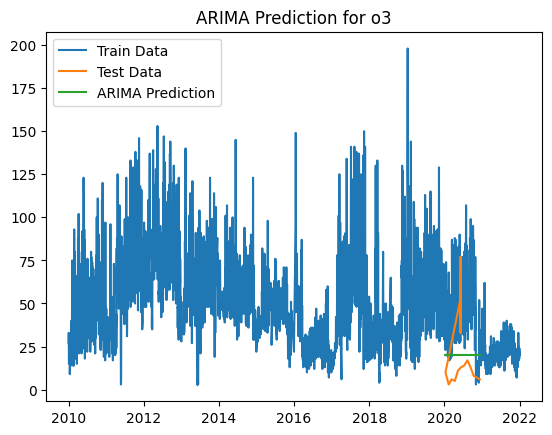

Train RMSE for o3: 16.449970024405385
Test RMSE for o3: 28.523142363785883
Train MAPE for o3: 0.2987331663975735
Test MAPE for o3: 0.9335936761183108


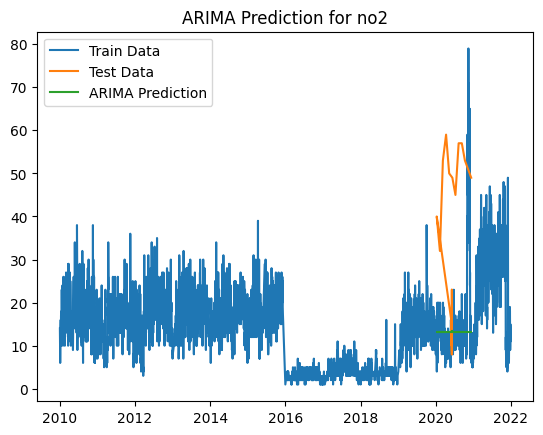

Train RMSE for no2: 4.366414770364118
Test RMSE for no2: 20.971690592845235
Train MAPE for no2: 0.25355940212658806
Test MAPE for no2: 0.39700892787914643


In [ ]:
arima_model = {}
arima_train_pred = {}
arima_test_pred = {}
for i in p:
    # Fitting ARIMA model
    arima_model[i] = ARIMA(df_train[i], order=(1, 1, 1)).fit()

    # Melakukan prediksi pada data pelatihan
    arima_train_pred[i] = arima_model[i].predict(start=df_train.index.min(), end=df_train.index.max(), dynamic=False)

    # Melakukan prediksi untuk data uji
    arima_test_pred[i] = arima_model[i].forecast(steps=len(df_test))

    # Memplot hasil prediksi
    plt.plot(df_train.index, df_train[i], label='Train Data')
    plt.plot(df_test.index, df_test[i], label='Test Data')
    plt.plot(df_test.index, arima_test_pred[i], label='ARIMA Prediction')
    plt.title(f'ARIMA Prediction for {i}')
    plt.legend()
    plt.show()

    # Menghitung RMSE dan MAPE
    train_rmse = mean_squared_error(df_train[i], arima_train_pred[i], squared=False)
    test_rmse = mean_squared_error(df_test[i], arima_test_pred[i], squared=False)
    train_mape = mean_absolute_percentage_error(df_train[i], arima_train_pred[i])
    test_mape = mean_absolute_percentage_error(df_test[i], arima_test_pred[i])

    # Menampilkan hasil evaluasi
    print(f'Train RMSE for {i}: {train_rmse}')
    print(f'Test RMSE for {i}: {test_rmse}')
    print(f'Train MAPE for {i}: {train_mape}')
    print(f'Test MAPE for {i}: {test_mape}')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/m7dgv77g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/3l18brsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46272', 'data', 'file=/tmp/tmpbqzij6th/m7dgv77g.json', 'init=/tmp/tmpbqzij6th/3l18brsn.json', 'output', 'file=/tmp/tmpbqzij6th/prophet_modelkfopr3e8/prophet_model-20240511024225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:42:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:42:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


len(prophet_train_pred[pm10])=3950
len(prophet_test_pred[pm10])=35


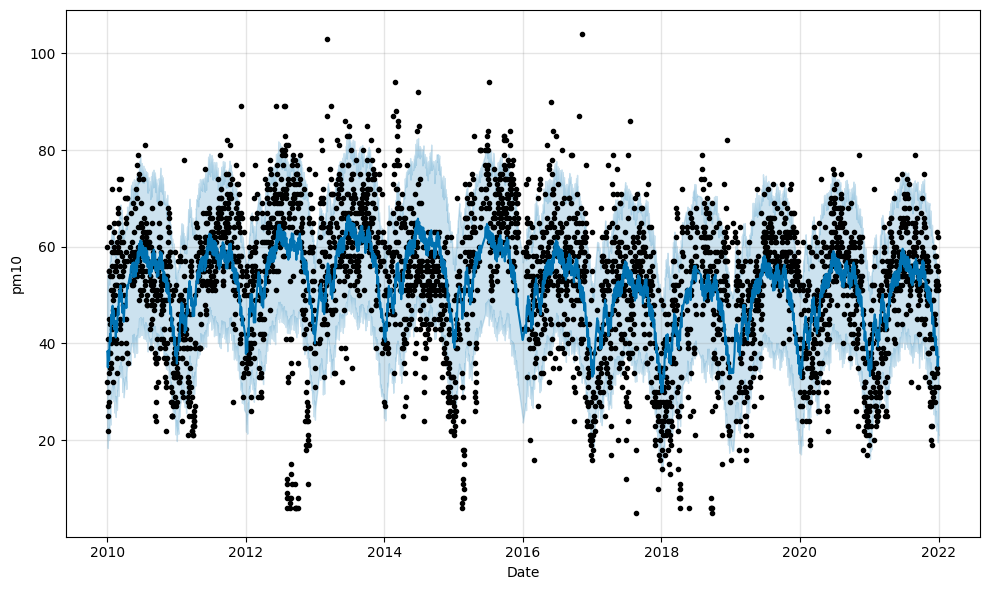

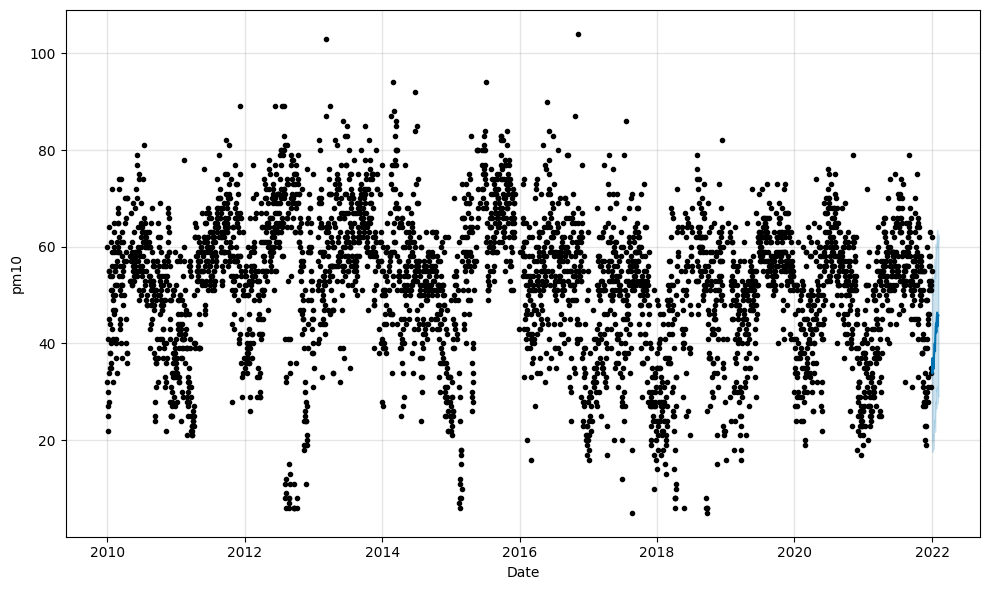

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/0bfyxegz.json


Train RMSE - pm10: 12.60085105653136
Test RMSE - pm10: 22.36702331216297
Train MAPE - pm10: 0.2712047092444256
Test MAPE - pm10: 0.34278851568773216


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/bxu4fmki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18472', 'data', 'file=/tmp/tmpbqzij6th/0bfyxegz.json', 'init=/tmp/tmpbqzij6th/bxu4fmki.json', 'output', 'file=/tmp/tmpbqzij6th/prophet_model63g7ndzq/prophet_model-20240511024228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


len(prophet_train_pred[so2])=3950
len(prophet_test_pred[so2])=35


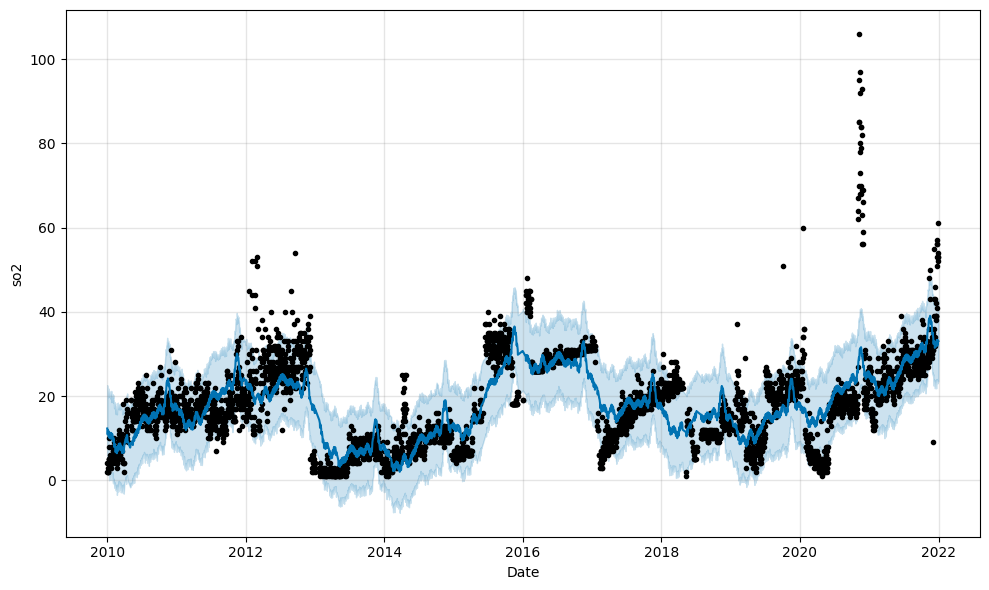

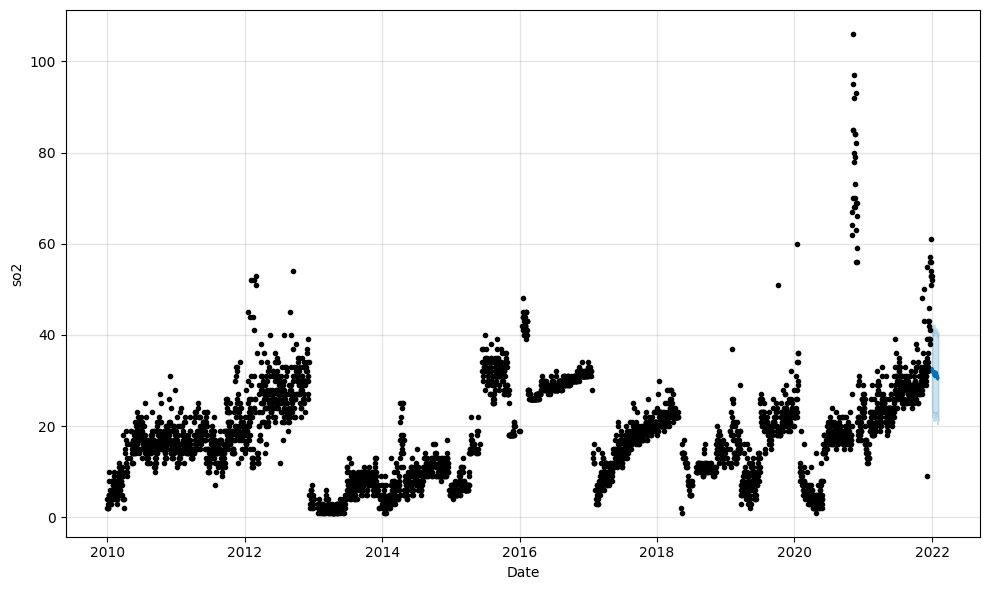

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/69ql2y0z.json


Train RMSE - so2: 7.372517062585692
Test RMSE - so2: 30.323474247094193
Train MAPE - so2: 0.497875747519631
Test MAPE - so2: 0.8102401283173428


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/1ur1912u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40967', 'data', 'file=/tmp/tmpbqzij6th/69ql2y0z.json', 'init=/tmp/tmpbqzij6th/1ur1912u.json', 'output', 'file=/tmp/tmpbqzij6th/prophet_model_wilx_b9/prophet_model-20240511024232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


len(prophet_train_pred[co])=3950
len(prophet_test_pred[co])=35


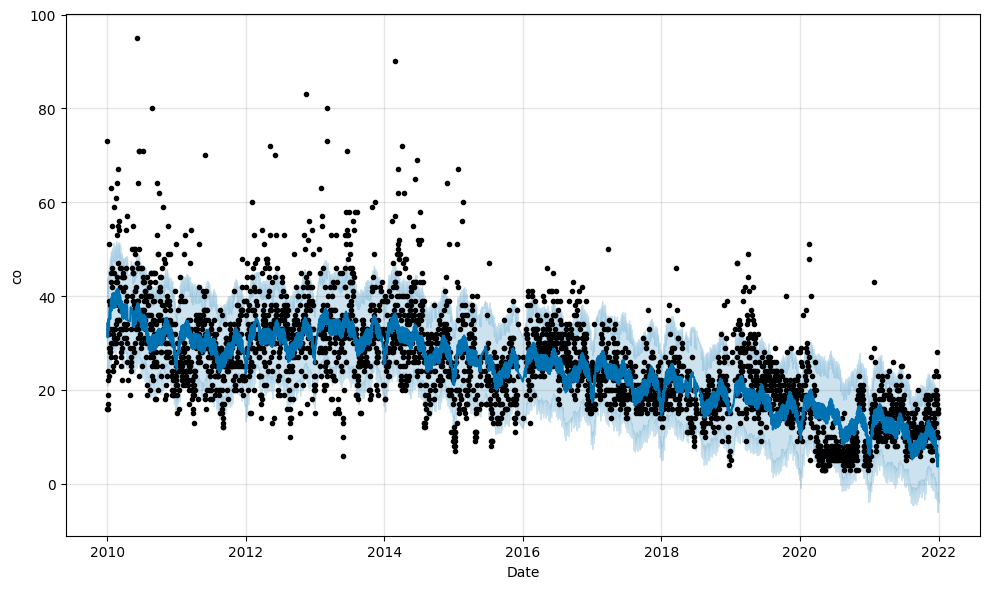

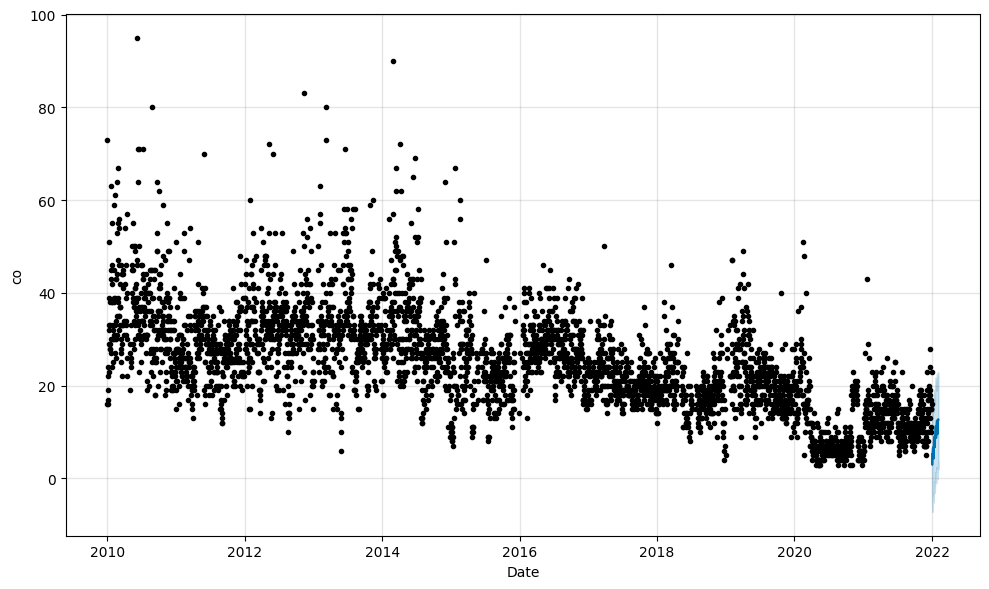

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/fnshb6vd.json


Train RMSE - co: 7.780617315380386
Test RMSE - co: 4.626662886934243
Train MAPE - co: 0.3006945102945118
Test MAPE - co: 0.3519019211716781


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/57zckx7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74424', 'data', 'file=/tmp/tmpbqzij6th/fnshb6vd.json', 'init=/tmp/tmpbqzij6th/57zckx7y.json', 'output', 'file=/tmp/tmpbqzij6th/prophet_modeloqtd8uvh/prophet_model-20240511024235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


len(prophet_train_pred[o3])=3950
len(prophet_test_pred[o3])=35


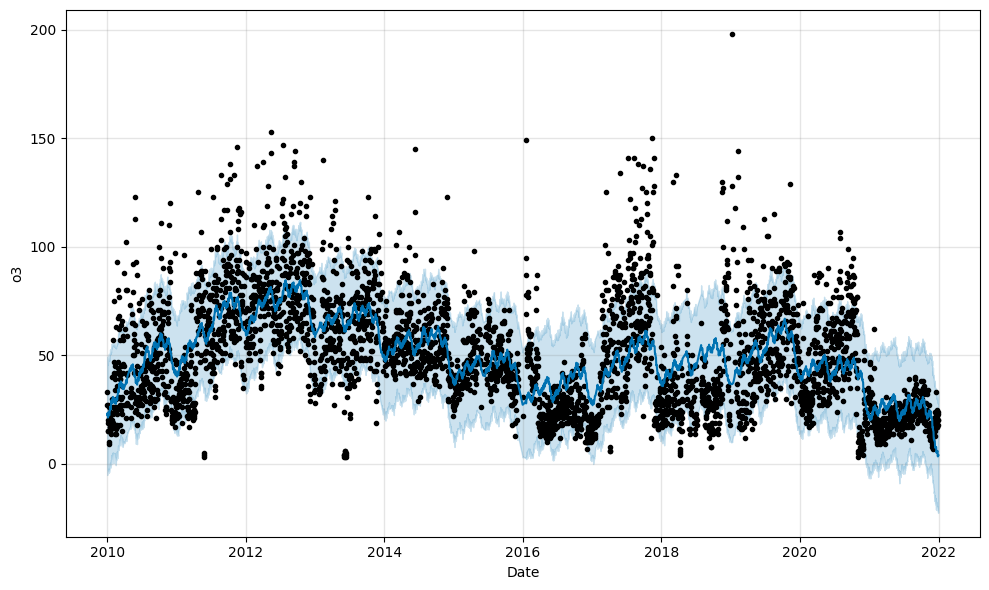

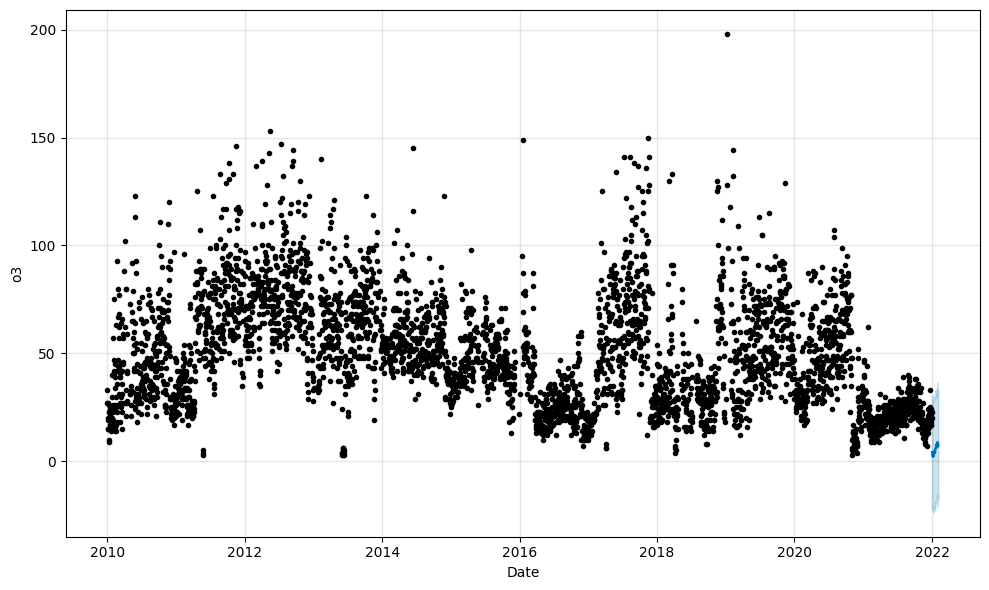

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/n200k4fy.json


Train RMSE - o3: 20.21814249465061
Test RMSE - o3: 40.477138446251196
Train MAPE - o3: 0.4692012720147198
Test MAPE - o3: 0.7720415176808512


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqzij6th/v_73jadw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88857', 'data', 'file=/tmp/tmpbqzij6th/n200k4fy.json', 'init=/tmp/tmpbqzij6th/v_73jadw.json', 'output', 'file=/tmp/tmpbqzij6th/prophet_modelm8u4o10d/prophet_model-20240511024239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:42:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


len(prophet_train_pred[no2])=3950
len(prophet_test_pred[no2])=35


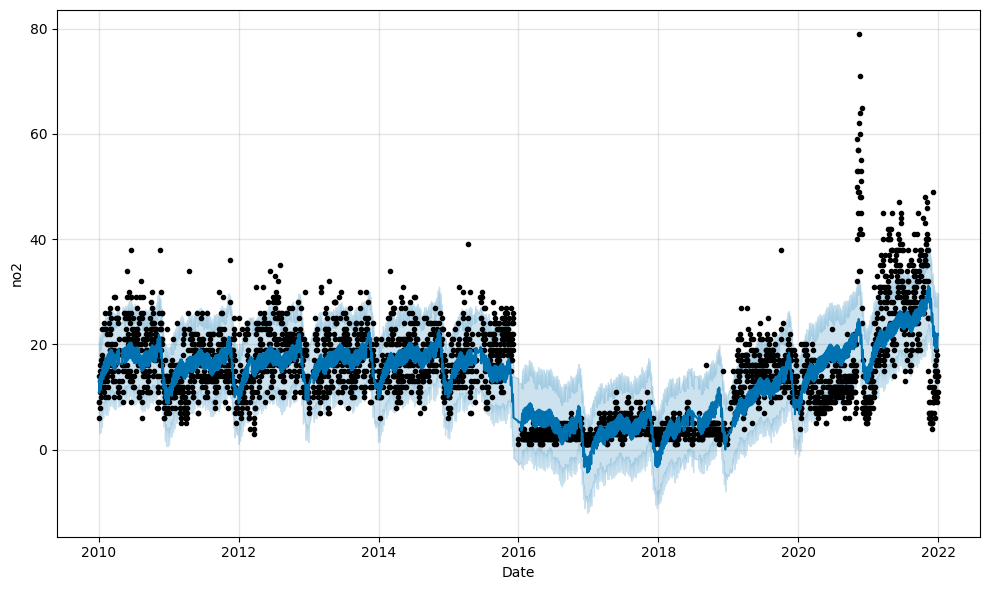

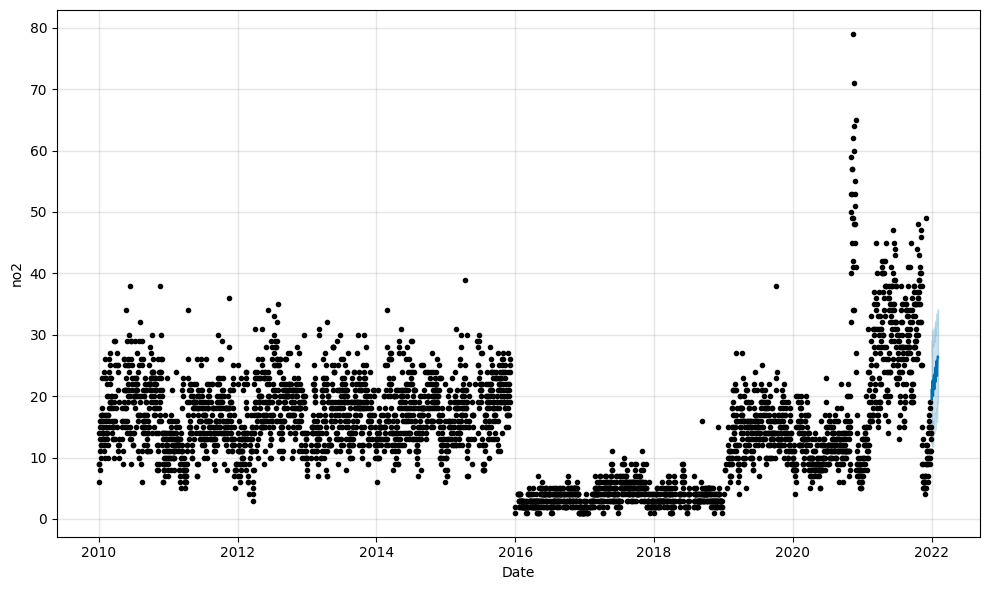

Train RMSE - no2: 6.014487627112738
Test RMSE - no2: 16.631367560105208
Train MAPE - no2: 0.47090330155064525
Test MAPE - no2: 0.7907360011644218


In [ ]:
# Facebook Prophet
prophet_model = {}
prophet_train_pred = {}
prophet_test_pred = {}
for i in p:
  df_prophet = pd.DataFrame()
  df_prophet['ds'] = df_train.index
  df_prophet['y'] = df_train[i].values
  prophet_model[i] = Prophet()
  prophet_model[i].fit(df_prophet)
  future = prophet_model[i].make_future_dataframe(periods=35, freq='D')
  prophet_train_pred[i] = prophet_model[i].predict(df_prophet)
  prophet_test_pred[i] = prophet_model[i].predict(future.tail(35))
  print(f'len(prophet_train_pred[{i}])={len(prophet_train_pred[i])}')
  print(f'len(prophet_test_pred[{i}])={len(prophet_test_pred[i])}')
  prophet_model[i].plot(prophet_train_pred[i], xlabel='Date', ylabel=i)
  prophet_model[i].plot(prophet_test_pred[i], xlabel='Date', ylabel=i)
  plt.show()
  print(f'Train RMSE - {i}:',mean_squared_error(df_train[i], prophet_train_pred[i]['yhat'][:len(df_train)])**0.5)
  print(f'Test RMSE - {i}:', mean_squared_error(df_test[i], prophet_test_pred[i]['yhat'])**0.5)
  print(f'Train MAPE - {i}:', mean_absolute_percentage_error(df_train[i], prophet_train_pred[i]['yhat'][:len(df_train)]))
  print(f'Test MAPE - {i}:', mean_absolute_percentage_error(df_test[i], prophet_test_pred[i]['yhat']))

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Support Vector Machine
from sklearn.svm import SVC

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
from xgboost import XGBClassifier
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Mengimpor library yang diperlukan untuk model LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

### **LTSM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import tensorflow.keras.callbacks as KC

In [ ]:
# Data untuk LSTM
data_lstm = df_train['pm10'].values.reshape(-1, 1)

In [ ]:
# Prapemrosesan data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_lstm)

In [ ]:
# Fungsi untuk membuat dataset dengan time step
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [ ]:
# Pembagian data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(data_scaled, data_scaled, test_size=0.2)

In [ ]:
# Time step dan pembuatan dataset
time_steps = 10
X_train, y_train = create_dataset(X_train, time_steps)
X_test, y_test = create_dataset(X_test, time_steps)

In [ ]:
# Konfigurasi model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])

In [ ]:
# Early stopping callback
early_stopping = KC.EarlyStopping(monitor='val_loss', patience=5)

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Pelatihan model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
99/99 [==============================] - 9s 39ms/step - loss: 0.0386 - val_loss: 0.0221
Epoch 2/50
99/99 [==============================] - 1s 15ms/step - loss: 0.0243 - val_loss: 0.0217
Epoch 3/50
99/99 [==============================] - 1s 15ms/step - loss: 0.0241 - val_loss: 0.0216
Epoch 4/50
99/99 [==============================] - 1s 15ms/step - loss: 0.0239 - val_loss: 0.0223
Epoch 5/50
99/99 [==============================] - 1s 13ms/step - loss: 0.0233 - val_loss: 0.0234
Epoch 6/50
99/99 [==============================] - 1s 14ms/step - loss: 0.0232 - val_loss: 0.0223
Epoch 7/50
99/99 [==============================] - 1s 13ms/step - loss: 0.0235 - val_loss: 0.0215
Epoch 8/50
99/99 [==============================] - 1s 13ms/step - loss: 0.0235 - val_loss: 0.0216
Epoch 9/50
99/99 [==============================] - 2s 18ms/step - loss: 0.0230 - val_loss: 0.0215
Epoch 10/50
99/99 [==============================] - 2s 24ms/step - loss: 0.0233 - val_loss: 0.0215
Epoch 11/

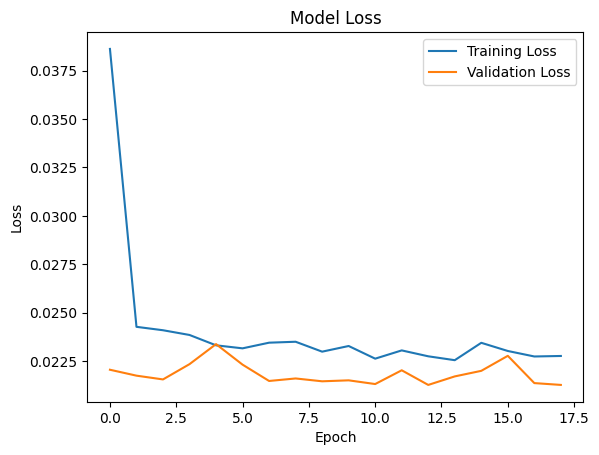

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
# Menggunakan model LSTM untuk membuat prediksi
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

25/25 [==============================] - 0s 5ms/step


In [ ]:
# Mengembalikan data yang telah dinormalisasi ke dalam skala aslinya
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)

test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

In [ ]:
# Menampilkan performa model LSTM
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 14.603406943514639
Test RMSE: 14.439066489844741


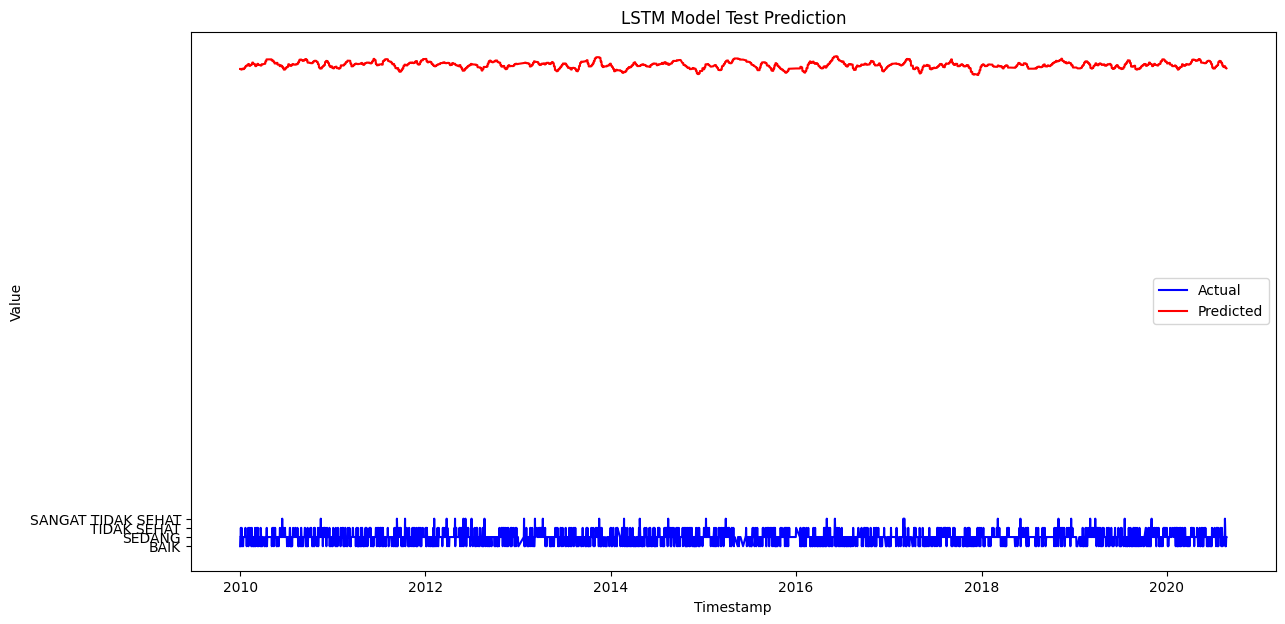

In [ ]:
# Mengonversi test_pred agar sesuai dengan panjang timestamps
test_pred = np.resize(test_pred, len(timestamps))

# Kemudian plot data
plt.figure(figsize=(14, 7))
plt.plot(timestamps, y_test, label='Actual', color='blue')
plt.plot(timestamps, test_pred, label='Predicted', color='red')
plt.title('LSTM Model Test Prediction')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


### **NAIVE BAYES**

In [ ]:
df = pd.read_csv('/content/data_AQ1.csv')

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Mengubah kategori menjadi one-hot encoding
X = pd.get_dummies(df.drop(columns=['categori', 'tanggal']))

# Mengubah label kategori menjadi bentuk numerik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['categori'])

In [ ]:
# Pembagian data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Pastikan 'tanggal' diubah menjadi tipe data datetime
#df['tanggal'] = pd.to_datetime(df['tanggal'])

In [ ]:
# Mengekstrak tahun, bulan, dan hari dari kolom tanggal
#df['tahun'] = df['tanggal'].dt.year
#df['bulan'] = df['tanggal'].dt.month
#df['hari'] = df['tanggal'].dt.day

In [ ]:
# Membuat fitur dan label
#X = df.drop(columns=['categori', 'tanggal'])  # Menghapus kolom 'categori' dan 'tanggal' dari fitur
#y = df['categori']

In [ ]:
# Melatih model Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(X, y)

GaussianNB()

In [ ]:
df.head()

,tanggal,stasiun,pm10,so2,co,o3,no2,max,critical,categori,tahun,bulan,hari
0,2010-01-01,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73,CO,SEDANG,2010,1,1
1,2010-01-02,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33,O3,BAIK,2010,1,2
2,2010-01-03,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27,PM10,BAIK,2010,1,3
3,2010-01-04,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22,PM10,BAIK,2010,1,4
4,2010-01-05,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25,PM10,BAIK,2010,1,5


In [ ]:
# Membuat prediksi menggunakan model
naive_bayes_train_pred = naive_bayes.predict(X_train)
naive_bayes_test_pred = naive_bayes.predict(X_test)

In [ ]:
# Mengukur kinerja model
train_rmse_naive_bayes = mean_squared_error(y_train, naive_bayes_train_pred, squared=False)
test_rmse_naive_bayes = mean_squared_error(y_test, naive_bayes_test_pred, squared=False)

In [ ]:
# Menampilkan hasil
print("Train RMSE Naive Bayes:", train_rmse_naive_bayes)
print("Test RMSE Naive Bayes:", test_rmse_naive_bayes)

Train RMSE Naive Bayes: 0.9712296520581716
Test RMSE Naive Bayes: 0.9667602586700119


### **Decision Tree**

In [ ]:
df = pd.read_csv('/content/data_AQ1.csv')

In [ ]:
# Menentukan fitur (X) dan label target (y)
X = df.drop(columns=['categori'])
y = df['categori']

In [ ]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Melatih model Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
decision_tree_train_pred = decision_tree.predict(X_train)
decision_tree_test_pred = decision_tree.predict(X_test)

In [ ]:
train_rmse_decision_tree = mean_squared_error(y_train, decision_tree_train_pred, squared=False)
test_rmse_decision_tree = mean_squared_error(y_test, decision_tree_test_pred, squared=False)

In [ ]:
print("Train RMSE Decision Tree:", train_rmse_decision_tree)
print("Test RMSE Decision Tree:", test_rmse_decision_tree)

Train RMSE Decision Tree: 0.0
Test RMSE Decision Tree: 0.05102365494737321


### **SVM**

In [ ]:
# Melatih model Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [ ]:
svm_train_pred = svm.predict(X_train)
svm_test_pred = svm.predict(X_test)

In [ ]:
train_rmse_svm = mean_squared_error(y_train, svm_train_pred, squared=False)
test_rmse_svm = mean_squared_error(y_test, svm_test_pred, squared=False)

In [ ]:
print("Train RMSE SVM:", train_rmse_svm)
print("Test RMSE SVM:", test_rmse_svm)

Train RMSE SVM: 0.9772439751858474
Test RMSE SVM: 0.9971031225347105


### **Logistic Regression**

In [ ]:
# Melatih model Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [ ]:
logistic_regression_train_pred = logistic_regression.predict(X_train)
logistic_regression_test_pred = logistic_regression.predict(X_test)

In [ ]:
train_rmse_logistic_regression = mean_squared_error(y_train, logistic_regression_train_pred, squared=False)
test_rmse_logistic_regression = mean_squared_error(y_test, logistic_regression_test_pred, squared=False)

In [ ]:
print("Train RMSE Logistic Regression:", train_rmse_logistic_regression)
print("Test RMSE Logistic Regression:", test_rmse_logistic_regression)

Train RMSE Logistic Regression: 0.5641052198606871
Test RMSE Logistic Regression: 0.5679207594443174


### **K-Nearest Neighbors**

In [ ]:
# Melatih model K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
knn_train_pred = knn.predict(X_train)
knn_test_pred = knn.predict(X_test)

In [ ]:
train_rmse_knn = mean_squared_error(y_train, knn_train_pred, squared=False)
test_rmse_knn = mean_squared_error(y_test, knn_test_pred, squared=False)

In [ ]:
print("Train RMSE KNN:", train_rmse_knn)
print("Test RMSE KNN:", test_rmse_knn)

Train RMSE KNN: 0.302860590102174
Test RMSE KNN: 0.39007056762750636


### **XGBoost**

In [ ]:
# Melatih model XGBoost
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xgboost_train_pred = xgboost.predict(X_train)
xgboost_test_pred = xgboost.predict(X_test)

In [ ]:
train_rmse_xgboost = mean_squared_error(y_train, xgboost_train_pred, squared=False)
test_rmse_xgboost = mean_squared_error(y_test, xgboost_test_pred, squared=False)

In [ ]:
print("Train RMSE XGBoost:", train_rmse_xgboost)
print("Test RMSE XGBoost:", test_rmse_xgboost)

Train RMSE XGBoost: 0.0
Test RMSE XGBoost: 0.05102365494737321


### **AdaBoost**

In [ ]:
# Melatih model AdaBoost
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

AdaBoostClassifier()

In [ ]:
adaboost_train_pred = adaboost.predict(X_train)
adaboost_test_pred = adaboost.predict(X_test)

In [ ]:
train_rmse_adaboost = mean_squared_error(y_train, adaboost_train_pred, squared=False)
test_rmse_adaboost = mean_squared_error(y_test, adaboost_test_pred, squared=False)

In [ ]:
print("Train RMSE AdaBoost:", train_rmse_adaboost)
print("Test RMSE AdaBoost:", test_rmse_adaboost)

Train RMSE AdaBoost: 1.2776739843110154
Test RMSE AdaBoost: 1.3293378569727519


### **Random Forest**

In [ ]:
# Melatih model Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
random_forest_train_pred = random_forest.predict(X_train)
random_forest_test_pred = random_forest.predict(X_test)

In [ ]:
train_rmse_random_forest = mean_squared_error(y_train, random_forest_train_pred, squared=False)
test_rmse_random_forest = mean_squared_error(y_test, random_forest_test_pred, squared=False)

In [ ]:
print("Train RMSE Random Forest:", train_rmse_random_forest)
print("Test RMSE Random Forest:", test_rmse_random_forest)

Train RMSE Random Forest: 0.0
Test RMSE Random Forest: 0.05102365494737321


In [ ]:
# Mencari model dengan RMSE terendah pada data latih dan data uji
train_rmse_list = [train_rmse_naive_bayes, train_rmse_decision_tree, train_rmse_svm,
                   train_rmse_logistic_regression, train_rmse_knn, train_rmse_xgboost,
                   train_rmse_adaboost, train_rmse_random_forest, train_rmse]

test_rmse_list = [test_rmse_naive_bayes, test_rmse_decision_tree, test_rmse_svm,
                  test_rmse_logistic_regression, test_rmse_knn, test_rmse_xgboost,
                  test_rmse_adaboost, test_rmse_random_forest, test_rmse]

train_rmse_list_names = ["Naive Bayes", "Decision Tree", "SVM", "Logistic Regression",
                         "KNN", "XGBoost", "AdaBoost", "Random Forest", "LSTM"]

test_rmse_list_names = ["Naive Bayes", "Decision Tree", "SVM", "Logistic Regression",
                        "KNN", "XGBoost", "AdaBoost", "Random Forest", "LSTM"]

In [ ]:
# Model dengan RMSE terendah pada data latih dan data uji
best_train_rmse = min(train_rmse_list)
best_train_rmse_model = train_rmse_list_names[train_rmse_list.index(best_train_rmse)]

best_test_rmse = min(test_rmse_list)
best_test_rmse_model = test_rmse_list_names[test_rmse_list.index(best_test_rmse)]

In [ ]:
print("Best Train RMSE Model:", best_train_rmse_model)
print("Best Train RMSE:", best_train_rmse)

print("Best Test RMSE Model:", best_test_rmse_model)
print("Best Test RMSE:", best_test_rmse)

Best Train RMSE Model: Decision Tree
Best Train RMSE: 0.0
Best Test RMSE Model: Decision Tree
Best Test RMSE: 0.05102365494737321
